Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kde
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from spacy import load
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Loading Data 

In [2]:
path = "C:/Users/user/Downloads/DiceyTechHack"
data = pd.read_csv(path +"/InstagramData.csv",encoding="utf-8")

Data Familirization 

In [3]:
data.head(2)

,Date,Content Type,Sent by,Post,Impressions,Reach,Engagement Rate (per Impression),Engagement Rate (per Reach),Engagements,Reactions,Comments,Saves,Video Views,Media Views,Organic Video Views,Tags
0,1/30/2023 17:06,Carousel,,The new Naira banknotes in circulation have se...,39681,32418,0.05,0.06,1942,1261,56,625,0,0,0,Other
1,4/15/2022 9:04,Photo,Blessing Ubah,We hope the faith that this #GoodFriday restor...,29186,25055,0.06,0.07,1763,709,1033,21,0,0,0,Other


Data Preprocessing

In [4]:
data["Date"] = pd.to_datetime(data["Date"])
data["PostHour"] = data["Date"].dt.hour
data["PostMonth"] = data["Date"].dt.month_name()
data["PostYear"] = data["Date"].dt.year

Sentiment, Topic, AND entity recognition

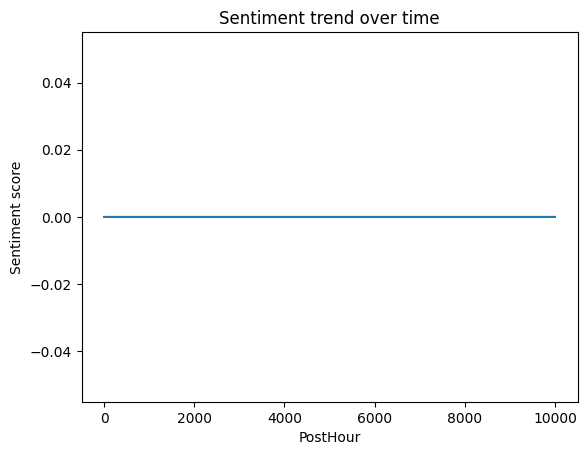

In [6]:
import re
df = pd.read_csv(path + '/InstagramData.csv', usecols=["Post"])

# Convert the 'Post' column to strings
df['Post'] = df['Post'].astype(str)

# Perform sentiment analysis
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []
for post in df['Post']:
    sentiment_score = sentiment_analyzer.polarity_scores(post)['compound']
    sentiment_scores.append(int(sentiment_score))

df['sentiment_score'] = sentiment_scores

# Perform topic modeling
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Post'])

lda = LatentDirichletAllocation(n_components=10)
lda_model = lda.fit(X)

topics = lda_model.components_
topic_names = ['Topic {}'.format(i) for i in range(len(topics))]

df['topic'] = lda_model.transform(X).argmax(axis=1)

# Perform entity recognition
nlp = load('en_core_web_sm')
entities = []
for post in df['Post']:
    doc = nlp(post)
    entities.append([entity.text for entity in doc.ents])

df['entities'] = entities

# Perform keyword analysis
keywords = []
for post in df['Post']:
    words = re.split(r'\W', post.lower())
    keywords.append(Counter(words).most_common(10))

df['keywords'] = keywords

# Identify trends
plt.plot(df['sentiment_score'])
plt.xlabel('PostHour')
plt.ylabel('Sentiment score')
plt.title('Sentiment trend over time')
plt.show()


In [7]:
data["Topic"] = df["topic"]
data["Entities"] = df["entities"]
data["Keywords"] = df["keywords"]

Text Analysis - Word Cloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


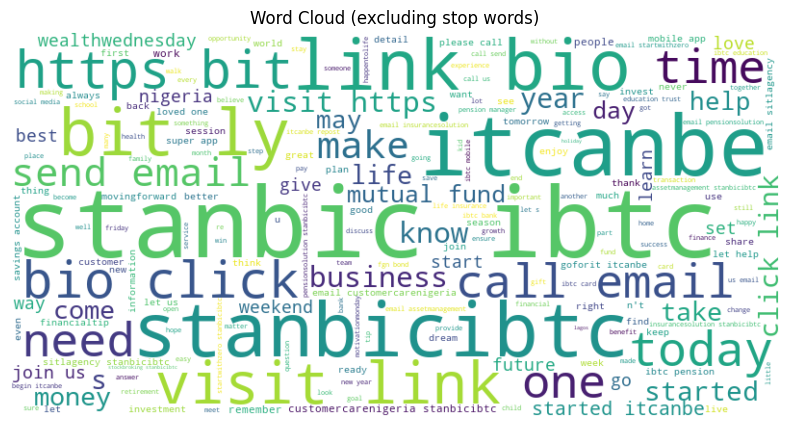

In [8]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Combine all the text from the 'post' column into a single string
all_text = ' '.join(df['Post'])

# Tokenize the text
tokens = word_tokenize(all_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

# Join the filtered tokens back into a string
filtered_text = ' '.join(filtered_tokens)

# Create a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (excluding stop words)')
plt.show()

In [9]:
data.columns

Index(['Date', 'Content Type', 'Sent by', 'Post', 'Impressions', 'Reach',
       'Engagement Rate (per Impression)', 'Engagement Rate (per Reach)',
       'Engagements', 'Reactions', 'Comments', 'Saves', 'Video Views',
       'Media Views', 'Organic Video Views', 'Tags', 'PostHour', 'PostMonth',
       'PostYear', 'Topic', 'Entities', 'Keywords'],
      dtype='object')

Content Analysis

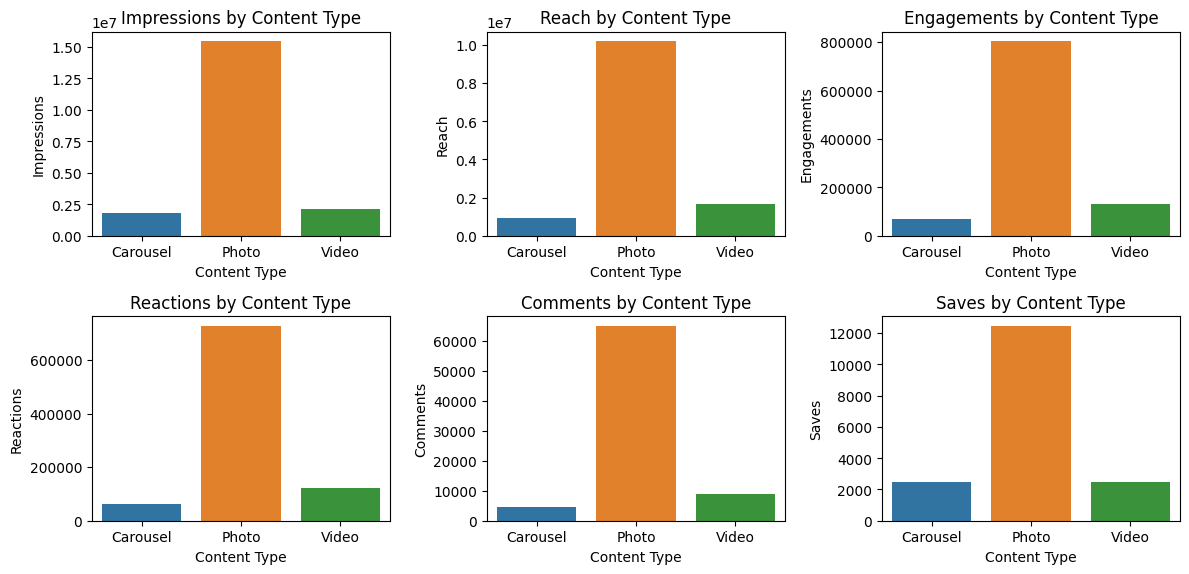

In [10]:
content_type_data = data.groupby('Content Type').sum().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

sns.barplot(x="Content Type", y="Impressions", data=content_type_data, ax=axes[0, 0])
sns.barplot(x="Content Type", y="Reach", data=content_type_data, ax=axes[0, 1])
sns.barplot(x="Content Type", y="Engagements", data=content_type_data, ax=axes[0, 2])
sns.barplot(x="Content Type", y="Reactions", data=content_type_data, ax=axes[1, 0])
sns.barplot(x="Content Type", y="Comments", data=content_type_data, ax=axes[1, 1])
sns.barplot(x="Content Type", y="Saves", data=content_type_data, ax=axes[1, 2])

axes[0, 0].set_title("Impressions by Content Type")
axes[0, 1].set_title("Reach by Content Type")
axes[0, 2].set_title("Engagements by Content Type")
axes[1, 0].set_title("Reactions by Content Type")
axes[1, 1].set_title("Comments by Content Type")
axes[1, 2].set_title("Saves by Content Type")

plt.tight_layout()

plt.show()

Sent By Analysis

Text(0.5, 1.0, 'Engagements by Sent by')

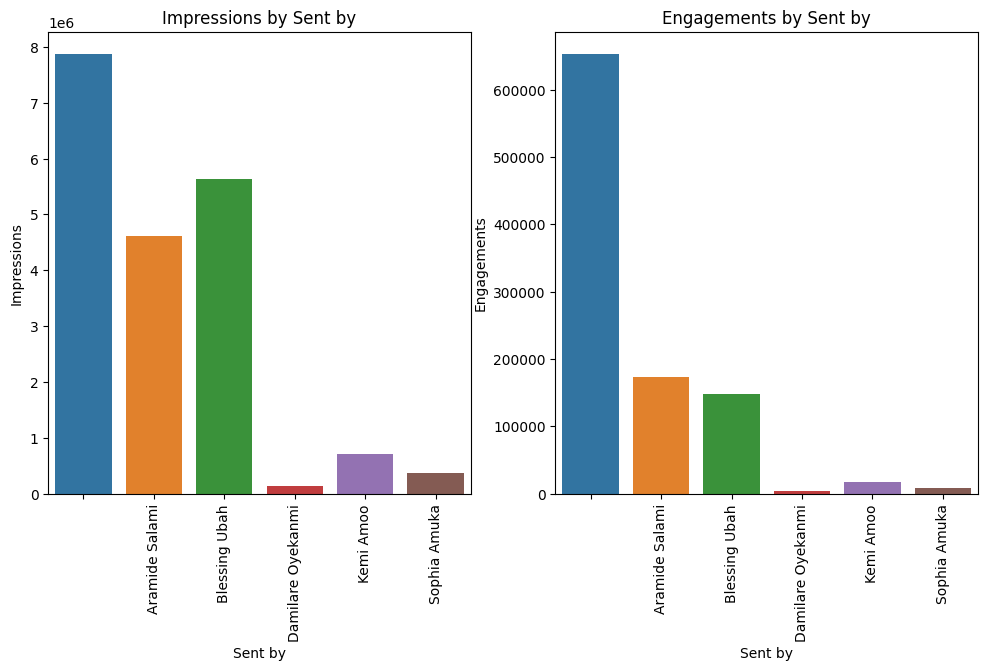

In [11]:
sent_by_data = data.groupby('Sent by').sum().reset_index()

#Plotting Content Type Analysis
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.barplot(x = "Sent by", y = "Impressions",data = sent_by_data)
plt.xticks(rotation=90)
plt.title("Impressions by Sent by")

plt.subplot(1,2,2)
sns.barplot(x = "Sent by", y = "Engagements",data = sent_by_data)
plt.xticks(rotation=90)
plt.title("Engagements by Sent by")

Hourly Analysis 

IndexError: index 5 is out of bounds for axis 0 with size 5

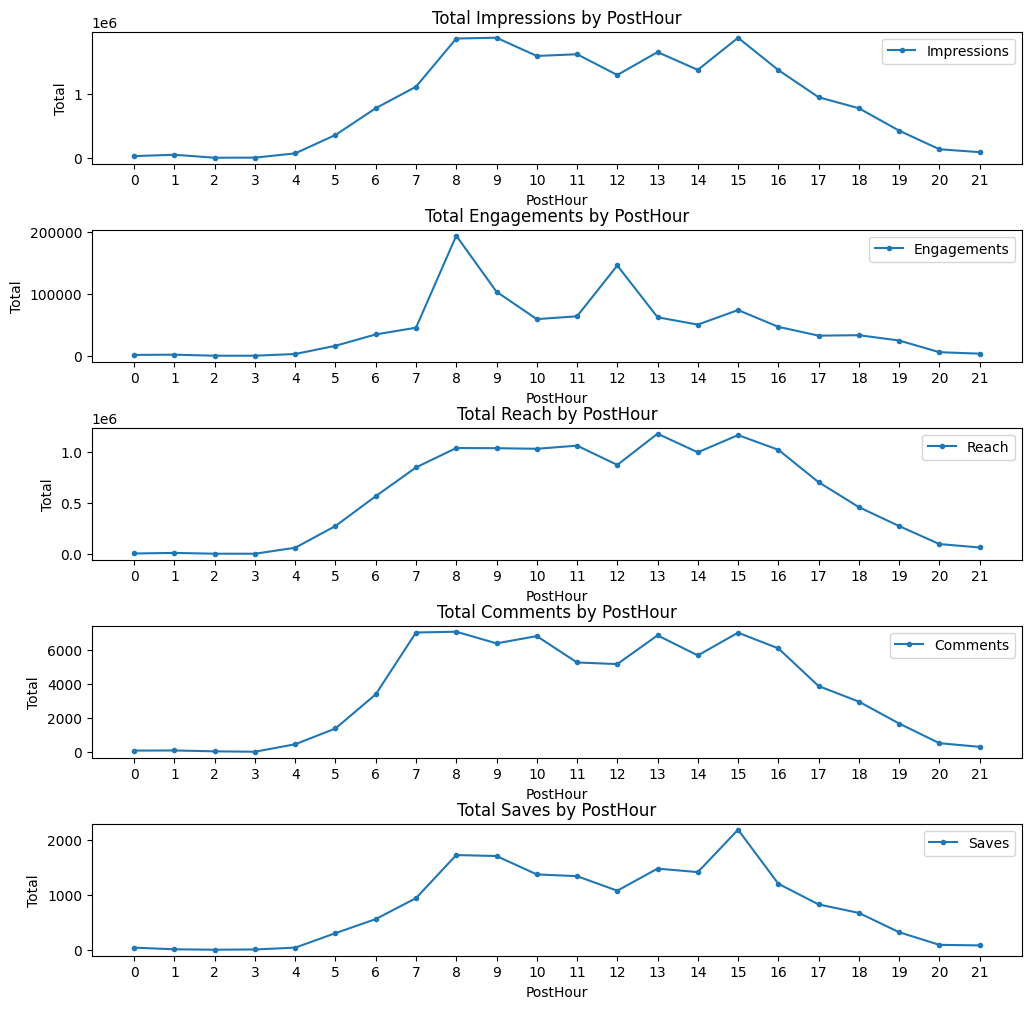

In [12]:
grouped_data = data.groupby('PostHour')[['Impressions', 'Engagements', 'Reach', 'Comments','Saves','Video Views','Media Views', 'Reactions']].sum()

hours = list(range(24))

hours = hours[:-2]

sorted_data = grouped_data.sort_values(by='PostHour')

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 12))

plt.subplots_adjust(hspace=0.5)

for i, metric in enumerate(['Impressions', 'Engagements','Reach','Comments','Saves','Video Views','Media Views', 'Reactions']):
    ax = axes[i]

    ax.plot(hours, sorted_data[metric], label=metric, marker='.')

    ax.set_title(f'Total {metric} by PostHour')
    ax.set_xlabel('PostHour')
    ax.set_ylabel('Total')

    ax.set_xticks(hours)

    ax.legend()

fig.suptitle('Total Metrics by PostHour')

plt.tight_layout()

plt.show()

Yearly and Monthly Analysis

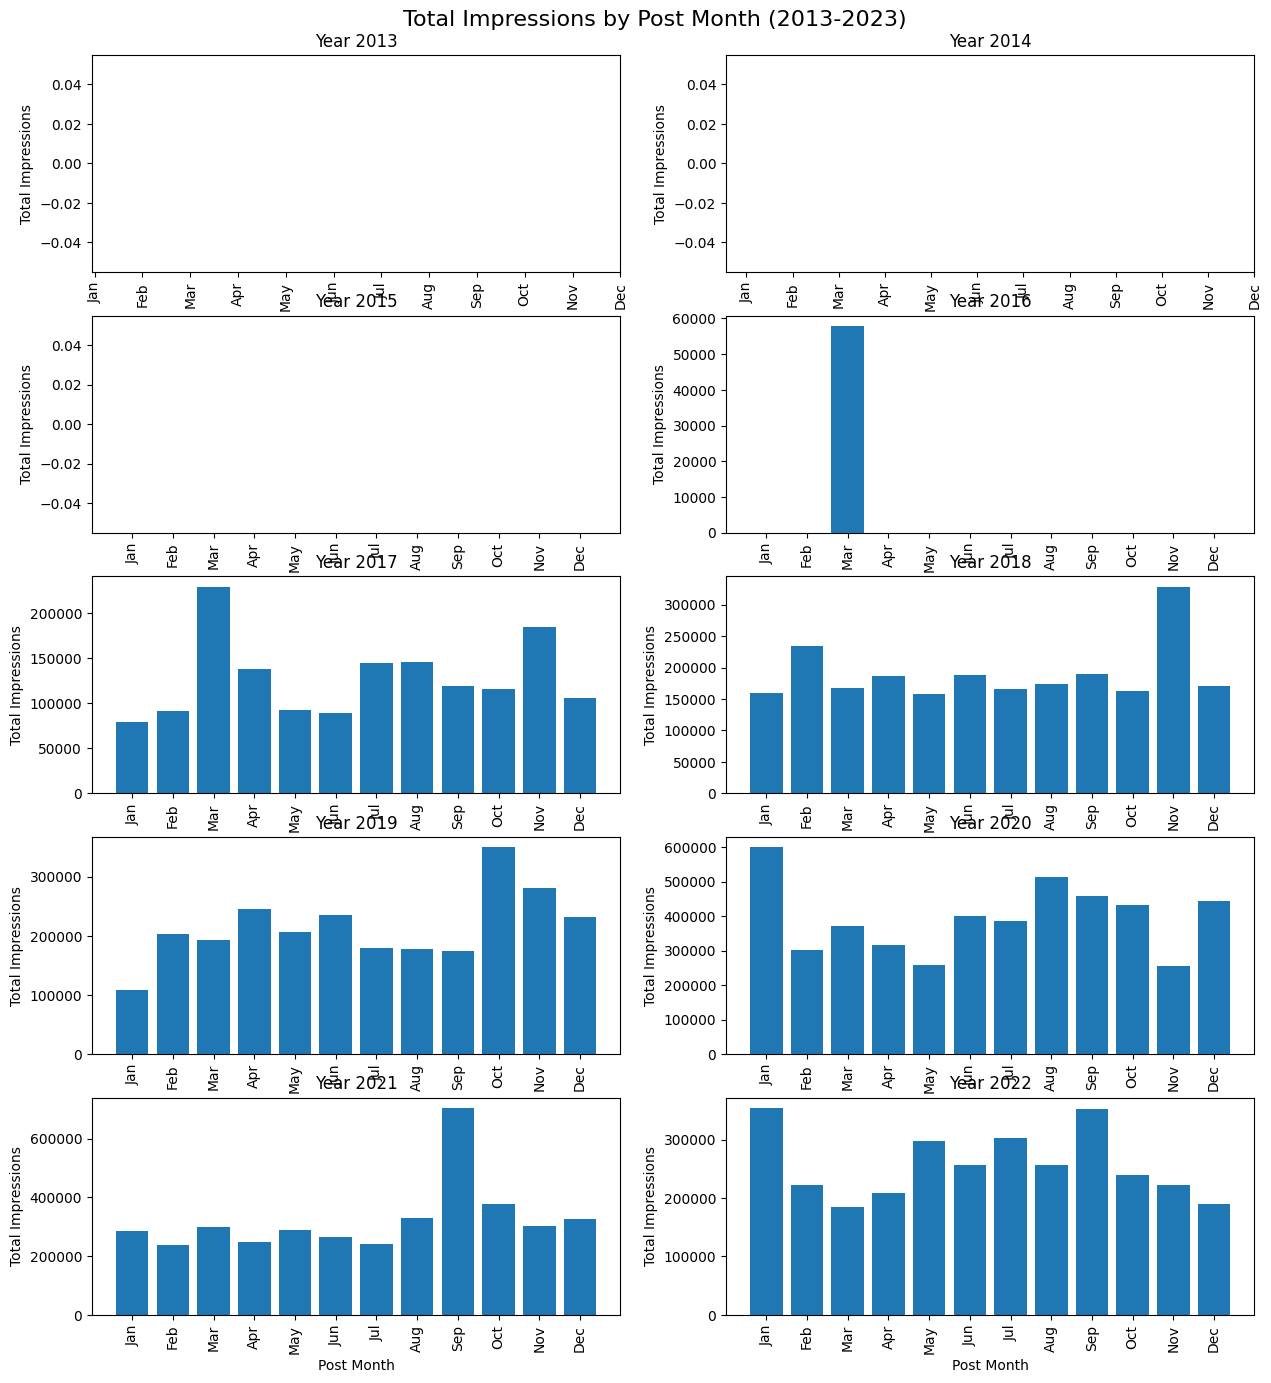

In [13]:
start_year = 2013
end_year = 2023

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
fig.suptitle('Total Impressions by Post Month (2013-2023)', fontsize=16)

for year,ax in zip(range(start_year, end_year + 1),axes.flat):
    
    filtered_data = data[data['PostYear'] == year]

    monthly_impressions_year = filtered_data.groupby('PostMonth')['Impressions'].sum()
    
    # Create a bar chart for the current year
    ax.bar(monthly_impressions_year.index, monthly_impressions_year.values)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Post Month')
    ax.set_ylabel('Total Impressions')
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=90)

# Adjust layout
plt.tight_layout
plt.subplots_adjust(top=0.95)

plt.show()

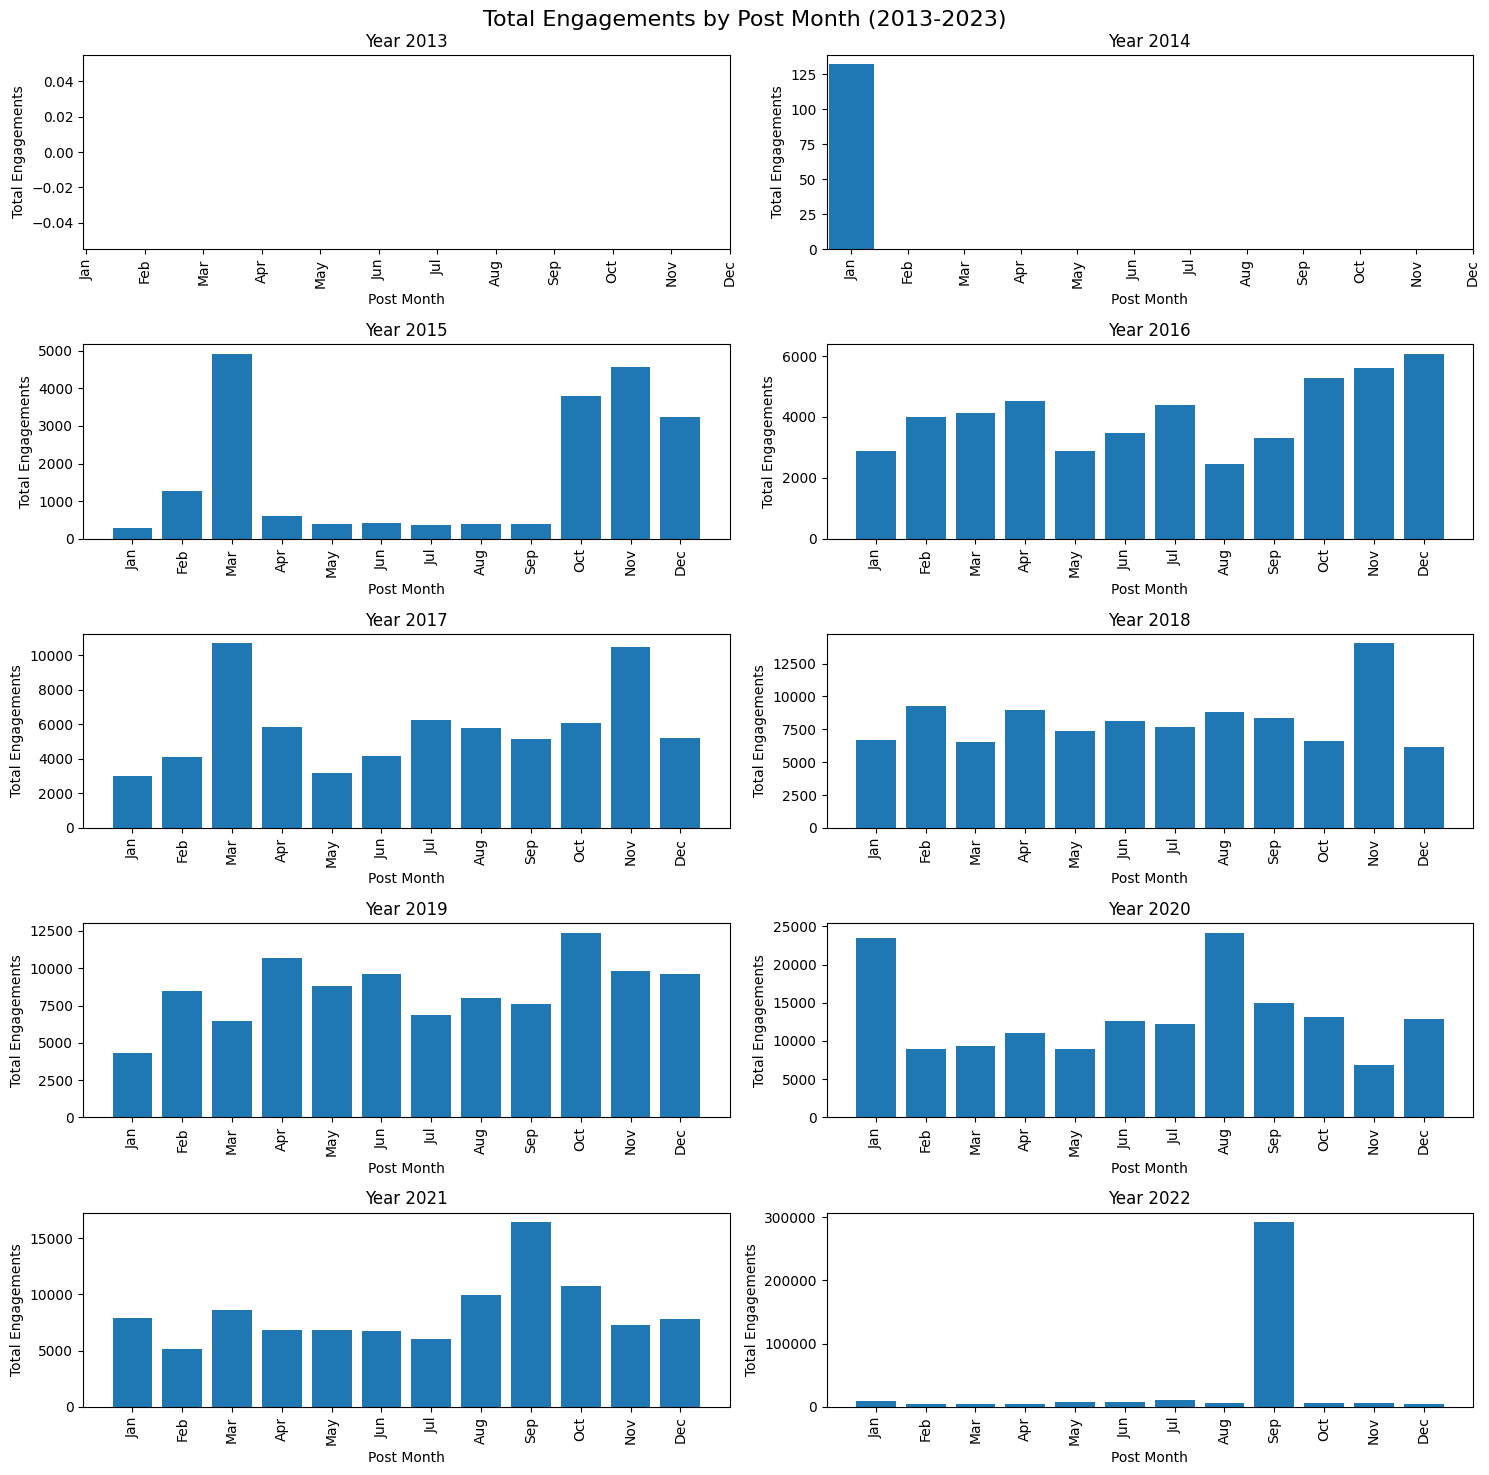

In [14]:
start_year = 2013
end_year = 2023

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
fig.suptitle('Total Engagements by Post Month (2013-2023)', fontsize=16)

for year,ax in zip(range(start_year, end_year + 1),axes.flat):
    
    filtered_data = data[data['PostYear'] == year]

    monthly_impressions_year = filtered_data.groupby('PostMonth')['Engagements'].sum()
    
    # Create a bar chart for the current year
    ax.bar(monthly_impressions_year.index, monthly_impressions_year.values)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Post Month')
    ax.set_ylabel('Total Engagements')
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=90)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Show the plots
plt.show()

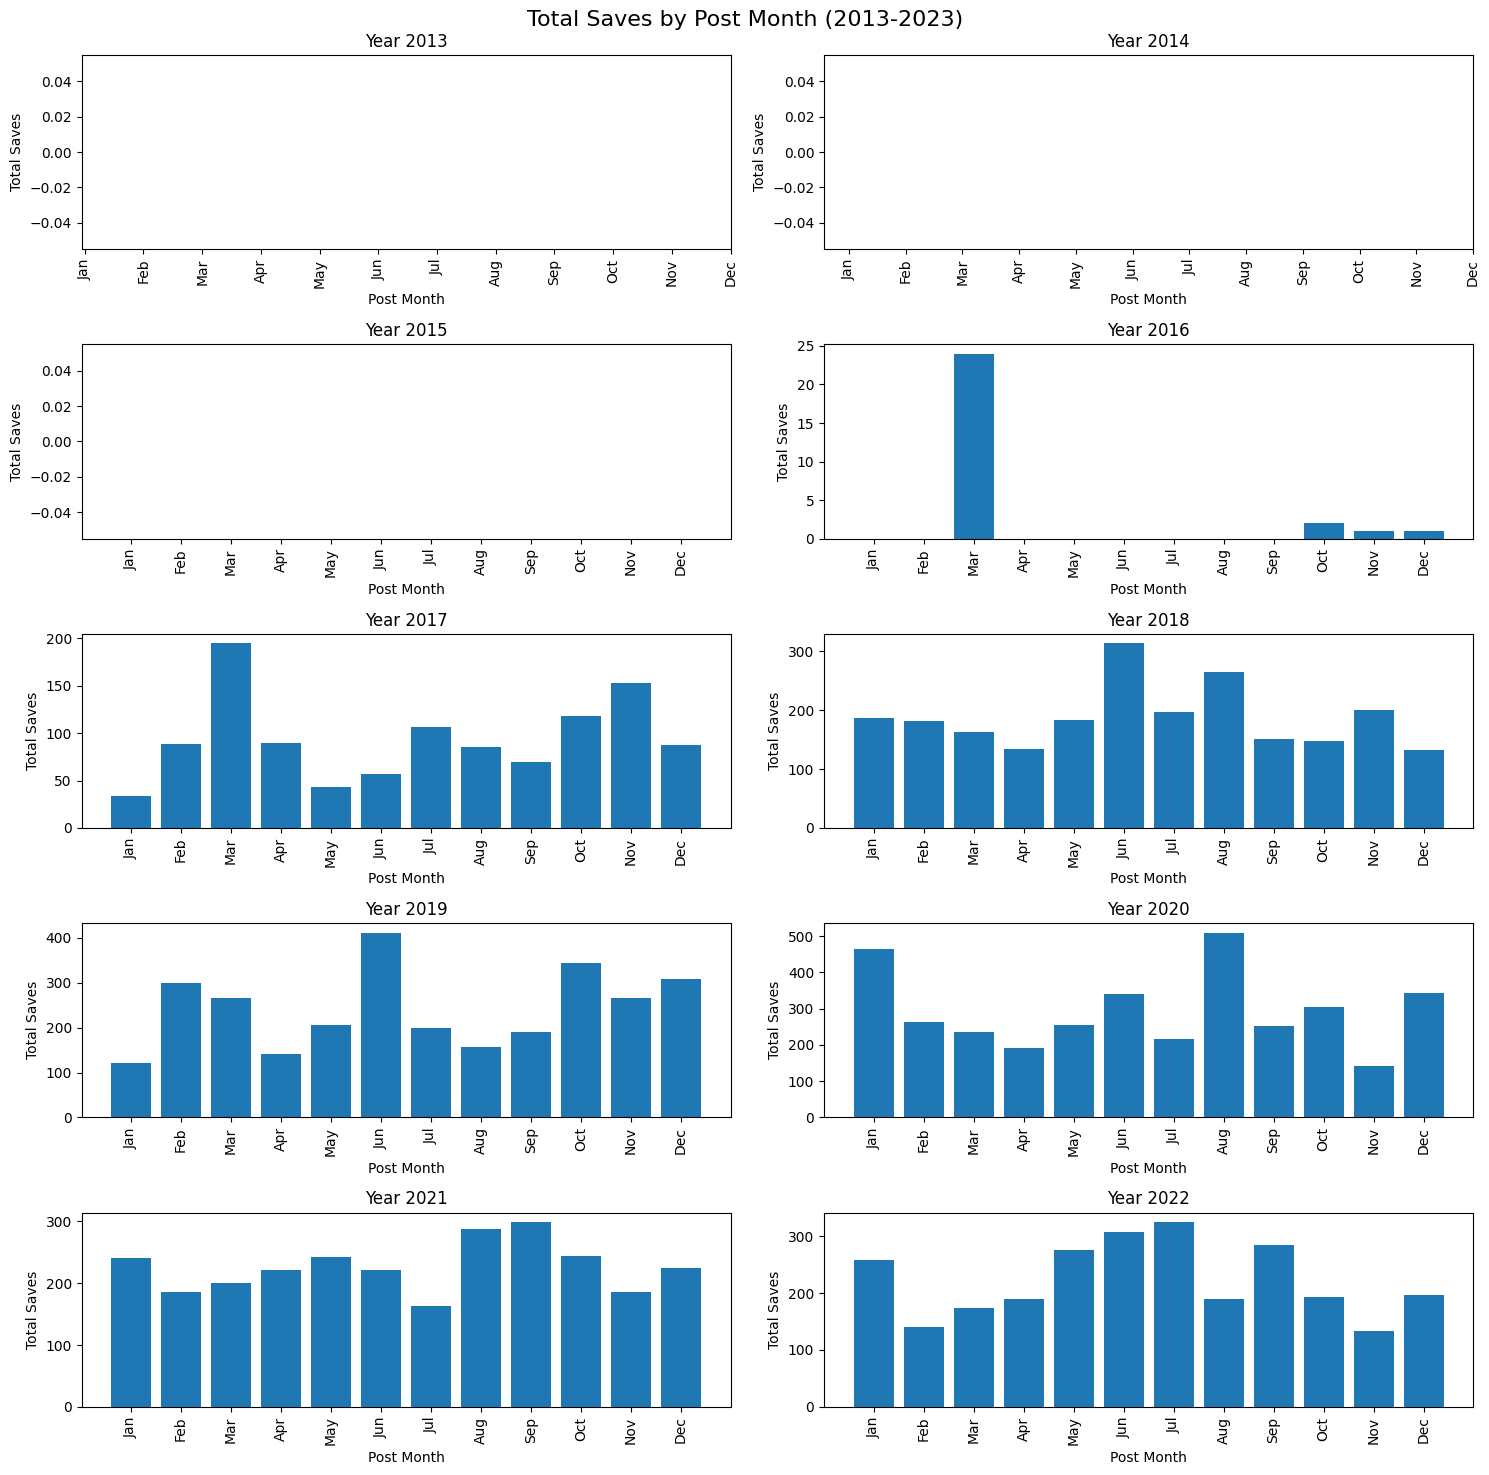

In [15]:
start_year = 2013
end_year = 2023

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
fig.suptitle('Total Saves by Post Month (2013-2023)', fontsize=16)

for year,ax in zip(range(start_year, end_year + 1),axes.flat):
    
    filtered_data = data[data['PostYear'] == year]

    monthly_impressions_year = filtered_data.groupby('PostMonth')['Saves'].sum()
    
    # Create a bar chart for the current year
    ax.bar(monthly_impressions_year.index, monthly_impressions_year.values)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Post Month')
    ax.set_ylabel('Total Saves')
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=90)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Show the plots
plt.show()

Top 5 Performing Years

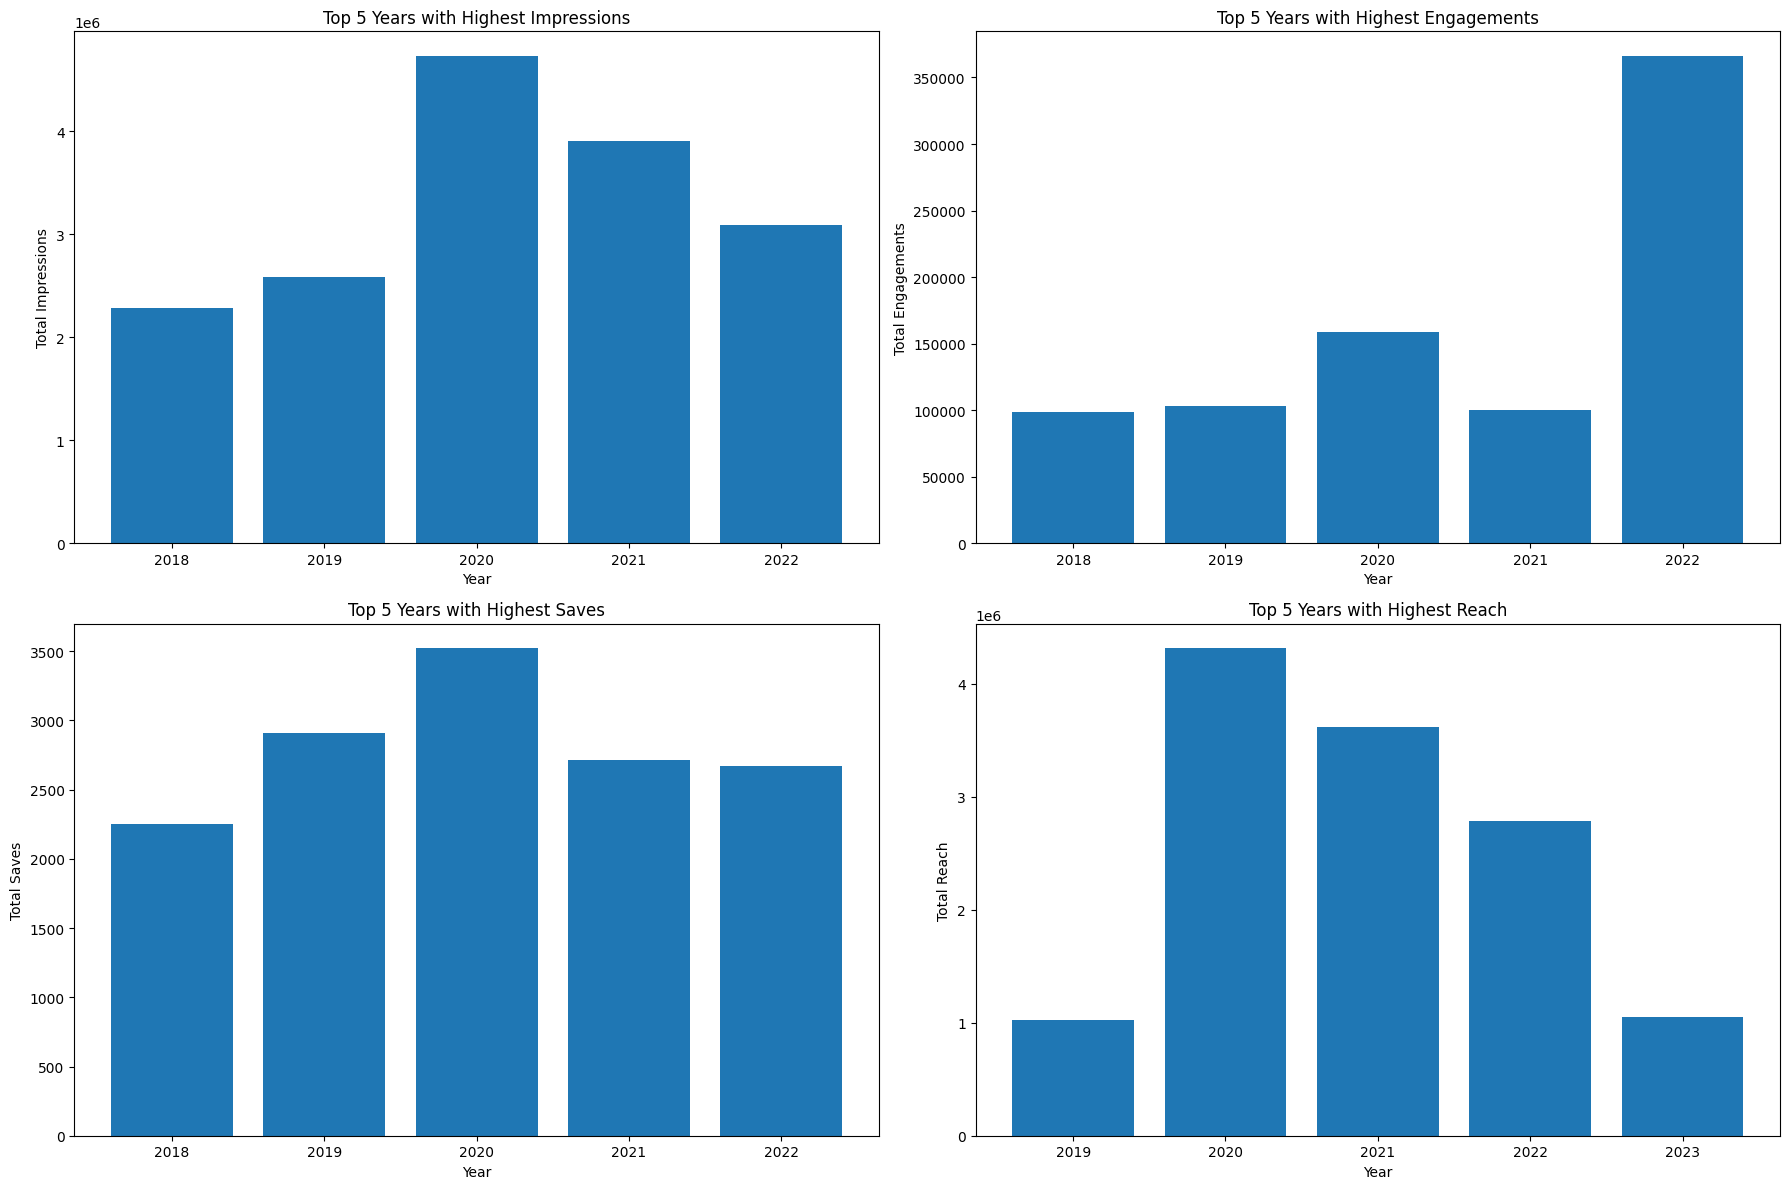

In [16]:
yearly_data = data.groupby('PostYear')[['Impressions', 'Engagements', 'Saves','Reach']].sum()

sorted_yearly_data = {}
for metric in ['Impressions', 'Engagements', 'Saves','Reach']:
    sorted_yearly_data[metric] = yearly_data.sort_values(by=metric, ascending=False)

top_5_years = {}
for metric in ['Impressions', 'Engagements', 'Saves','Reach']:
    top_5_years[metric] = sorted_yearly_data[metric].head(5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

for i, metric in enumerate(['Impressions', 'Engagements', 'Saves','Reach']):
    ax = axes[i // 2, i % 2]
    ax.bar(top_5_years[metric].index, top_5_years[metric][metric])
    ax.set_title(f'Top 5 Years with Highest {metric}')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Total {metric}')

plt.tight_layout()

plt.show()

Top 5 Performing Months

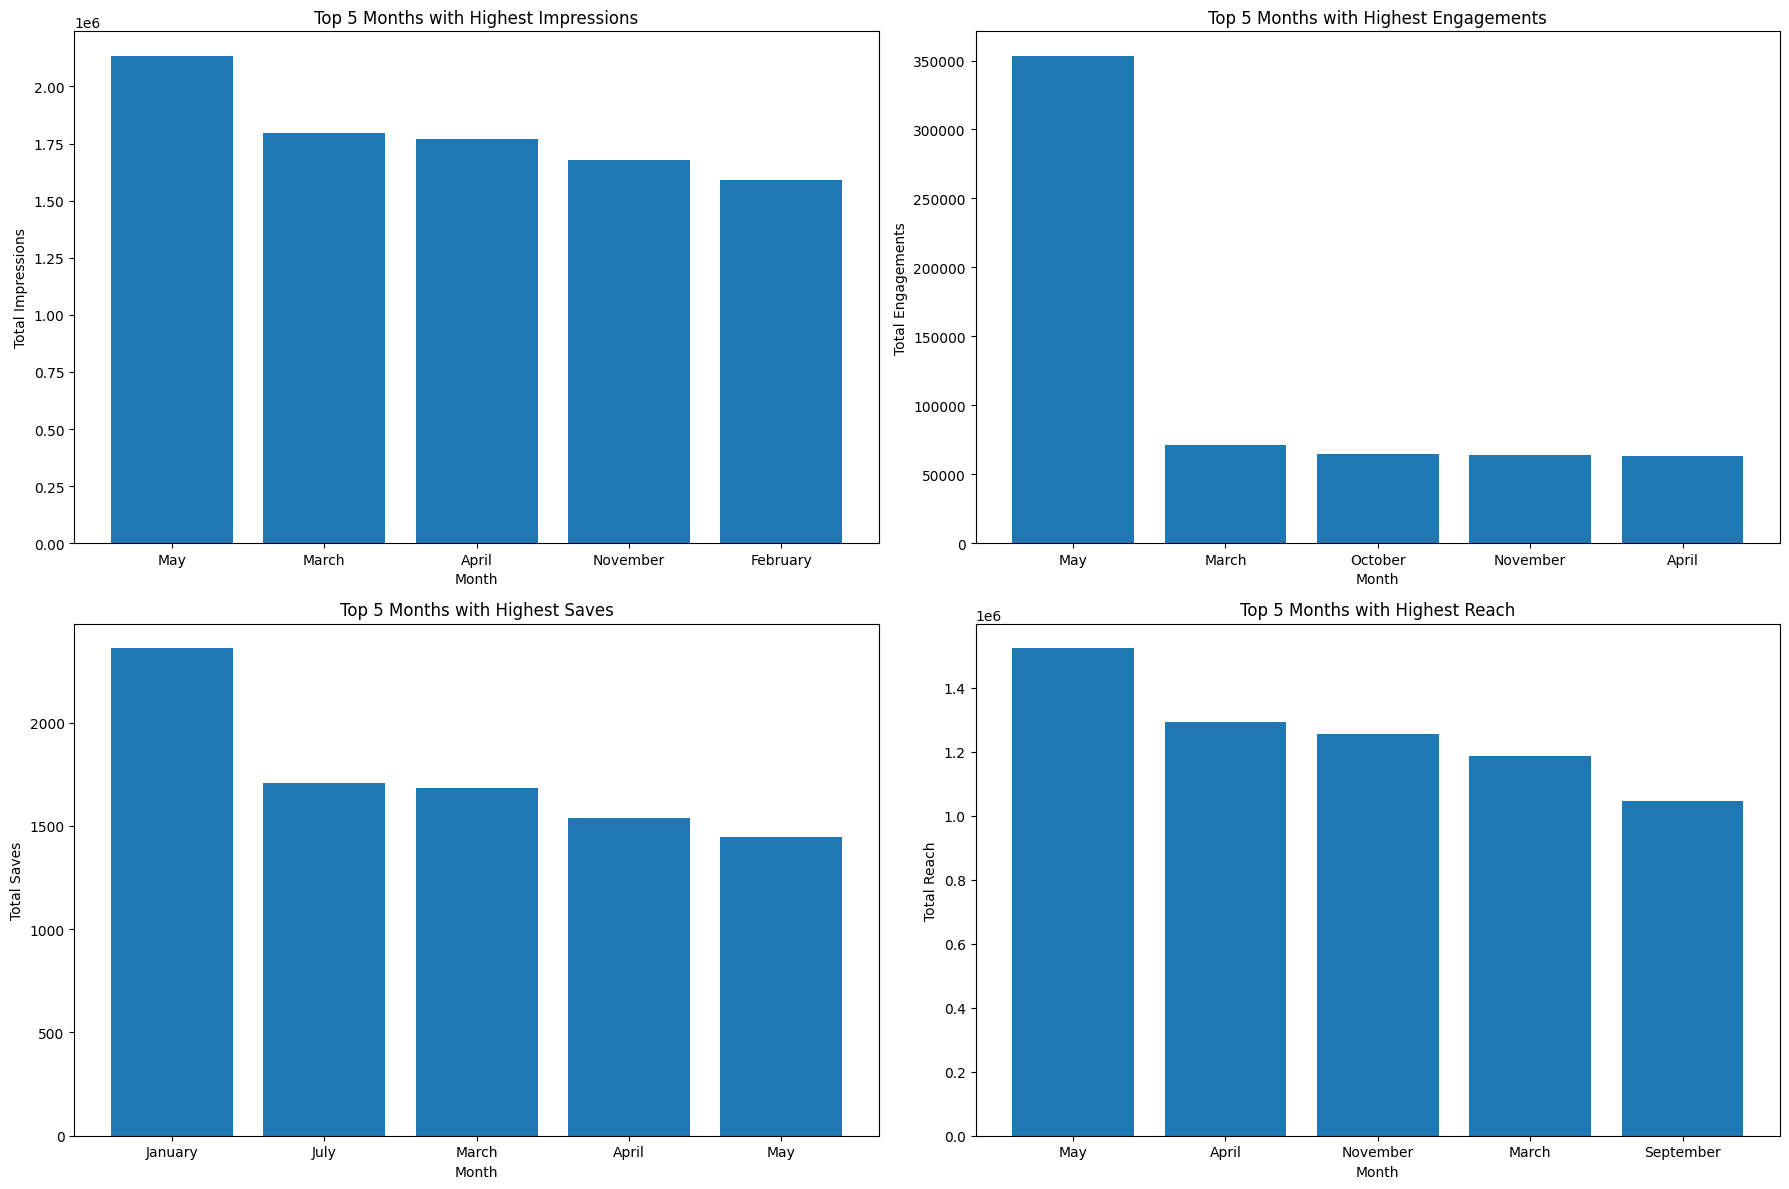

In [17]:
monthly_data = data.groupby('PostMonth')[['Impressions', 'Engagements', 'Saves','Reach']].sum()

sorted_monthly_data = {}
for metric in ['Impressions', 'Engagements', 'Saves','Reach']:
    sorted_monthly_data[metric] = monthly_data.sort_values(by=metric, ascending=False)

top_5_months = {}
for metric in ['Impressions', 'Engagements', 'Saves','Reach']:
    top_5_months[metric] = sorted_monthly_data[metric].head(5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

for i, metric in enumerate(['Impressions', 'Engagements', 'Saves','Reach']):
    ax = axes[i // 2, i % 2]
    ax.bar(top_5_months[metric].index, top_5_months[metric][metric])
    ax.set_title(f'Top 5 Months with Highest {metric}')
    ax.set_xlabel('Month')
    ax.set_ylabel(f'Total {metric}')

plt.tight_layout()

plt.show()

Post Duration Analysis

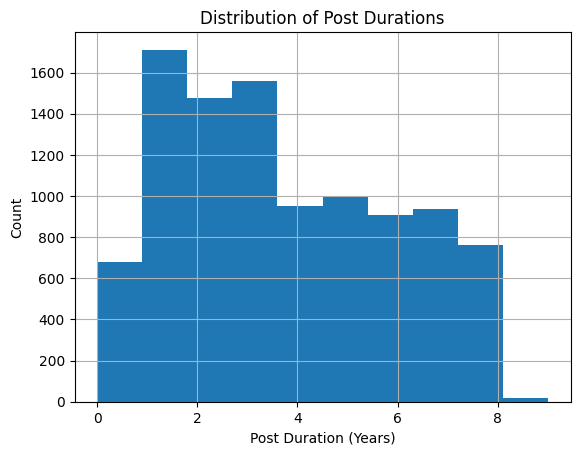

In [ ]:
average_post_duration = data['PostDuration'].mean()

min_post_duration = data['PostDuration'].min()
max_post_duration = data['PostDuration'].max()

post_duration_distribution = data['PostDuration'].hist()

plt.xlabel('Post Duration (Years)')
plt.ylabel('Count')
plt.title('Distribution of Post Durations')
plt.show()